In [1]:
# load packages
from imutils import face_utils
import imutils
import dlib
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# load the images
art_image_name = 'files/mona_lisa.jpg'
headshot_image_name = 'files/headshot.jpg'

In [3]:
# crop the image so it's just the face
def compute_face_crop(image_file):
    
    # This will take an image file, and will return information about where the face is, the image with the face bounding box, and the cropped image
    
    # read image, copy it so nothing funky happens, convert to grayscale for opencv
    image = cv2.imread(image_file,cv2.IMREAD_COLOR)
    image1 = np.copy(image)
    imgtest = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

    # load the face classifier
    facecascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    
    # run the face classifier for the image. returns bounding box of the face
    faces = facecascade.detectMultiScale(imgtest, scaleFactor=1.2, minNeighbors=5)
    # plot the image and the bounding box of the face
    if len(faces) > 2:
        display('too many faces')
        faces = []
        face_detect = []
        cropped_image = image
        return
    else:
        (x, y, w, h) = faces[0]
        pad = 25;
        image_size = np.shape(imgtest)
        # detect the face region
        minx = max(0,x-pad)
        miny= max(0,y-pad)
        maxx = min(image_size[1],x+w+pad)
        maxy = min(image_size[0],y+w+pad) 
        rectangle = (minx, miny, maxx, maxy)
        face_detect = cv2.rectangle(imgtest, (minx, miny), (maxx, maxy), (255, 0, 255), 2)

        # save the cropped image
        cropped_image = image1[miny:maxy, minx:maxx,:]
        
        return image, faces, face_detect, cropped_image, rectangle

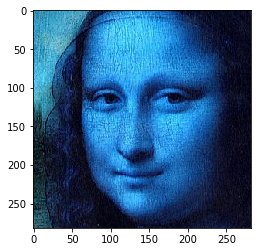

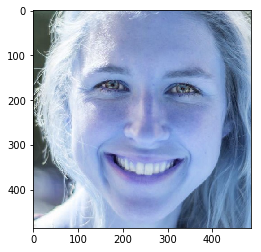

In [4]:
# compute the face cropped file for each image

# for the art image
art_image, art_faces, art_face_detect, art_cropped_image, art_rectangle = compute_face_crop(art_image_name)
plt.figure()
plt.imshow(art_cropped_image)

# for the headshot image
headshot_image, headshot_faces, headshot_face_detect, headshot_cropped_image, headshot_rectangle = compute_face_crop(headshot_image_name)
plt.figure()
plt.imshow(headshot_cropped_image)

In [5]:
# compute the face landmarks
# load the predictor from dlib
p = "files/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [6]:
def compute_landmarks(image):
    lm_image = np.copy(image)
    lm_image = cv2.cvtColor(lm_image, cv2.COLOR_BGR2GRAY)  
    detected_image = detector(lm_image, 0)
    points = predictor(lm_image, detected_image[0])
    points = face_utils.shape_to_np(points)
    
    # draw landmarks on face
    for (x, y) in points:
        cv2.circle(lm_image, (x, y), 2, (0, 0, 0), -1)
    
    return points, lm_image

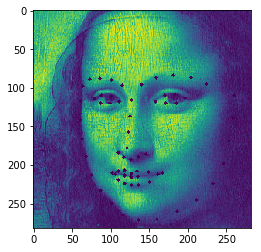

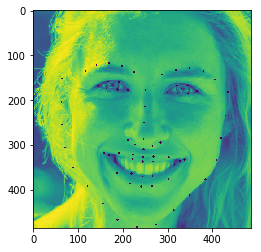

In [7]:
# compute the landmarks in the art and headshot faces
# for the art image
art_points1, art_cropped_lm_image = compute_landmarks(art_cropped_image)


cv2.imwrite('files/landmark_image.jpg',art_cropped_lm_image)


plt.figure()
plt.imshow(art_cropped_lm_image)
art_points = []
for x,y in art_points1:
    art_points.append((int(x), int(y)))

# for the headshot image
headshot_points1, headshot_cropped_lm_image = compute_landmarks(headshot_cropped_image)
plt.figure()
plt.imshow(headshot_cropped_lm_image)
headshot_points = []
for x,y in headshot_points1:
    headshot_points.append((int(x), int(y)))

In [8]:
# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

In [9]:
def calculateDelaunayTriangles(image, cx_hull_points):
    
    delaunay_color = (255,255,255)
    
    image_triangle = np.copy(image)
    sizeImg = image_triangle.shape    
    rect = (0, 0, sizeImg[1], sizeImg[0])
    
    #create subdiv
    subdiv = cv2.Subdiv2D(rect);

    # Insert points into subdiv
    for p in cx_hull_points:
        subdiv.insert(p)
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            
            cv2.line(image_triangle, pt1, pt2, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(image_triangle, pt2, pt3, delaunay_color, 1, cv2.LINE_AA, 0)
            cv2.line(image_triangle, pt3, pt1, delaunay_color, 1, cv2.LINE_AA, 0)
            
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(cx_hull_points)):                    
                    if(abs(pt[j][0] - cx_hull_points[k][0]) < 1.0 and abs(pt[j][1] - cx_hull_points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []       
            
    return delaunayTri, image_triangle

NameError: name 'dt_headshot' is not defined

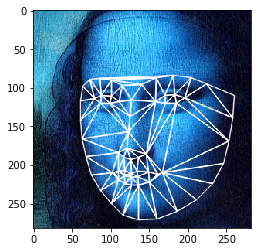

In [10]:
# find the Delaunay Triangulation for each image
#dt_art, art_triangles = calculateDelaunayTriangles(art_cropped_image, hullIndex_art)
dt_art, art_triangles = calculateDelaunayTriangles(art_cropped_image, art_points)
plt.figure()
plt.imshow(art_triangles)

# find the Delaunay Triangulation for each image
# dt_headshot, headshot_triangles  = calculateDelaunayTriangles(headshot_cropped_image, hullIndex_headshot)
dt_headshot, headshot_triangles  = calculateDelaunayTriangles(headshot_cropped_image, headshot_points)
plt.figure()
plt.imshow(headshot_triangles)

In [ ]:
def applyAffineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst

In [ ]:
def warpTriangle(img1, img2, t1, t2) :

    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 

In [ ]:
# compute the convex hull for each image
hullIndex_art = computeHullIndex(art_points1, art_points)
hullIndex_headshot = computeHullIndex(headshot_points1, headshot_points)

hull_art1 = []
hull_hs1 = []
for i in range(0, len(hullIndex_art1)):
    hull_hs1.append(headshot_points1[int(hullIndex_art1[i])])
    hull_art1.append(art_points1[int(hullIndex_art1[i])])

In [ ]:
# for every triangle, compute the warping to get from face to art photo


In [ ]:
# Calculate Mask and clone
hull8U = []
for i in range(0, len(hullIndex_art)):
    hull8U.append((hullIndex_art[i][0], hullIndex_art[i][1]))

mask = np.zeros(art_cropped_image.shape, dtype = art_cropped_image.dtype)  

cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

r = cv2.boundingRect(np.float32([hullIndex_art]))    

center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))

# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(headshot_cropped_image_warped), art_cropped_image, mask, center, cv2.NORMAL_CLONE)

In [ ]:
print(art_cropped_image.shape)

In [ ]:
# place the cropped image back into the original art image
minx, miny, maxx, maxy = art_rectangle 
blended_image = np.copy(art_image)
blended_image[miny:maxy, minx:maxx,:] = output

# plot things
plt.figure()
plt.imshow(art_cropped_image)
plt.figure()
plt.imshow(headshot_cropped_image)
plt.figure()
plt.imshow(output)
plt.figure()
plt.imshow(blended_image)

output_name = 'files/output_image.jpg'
cv2.imwrite('files/output_image_allpoints.jpg',blended_image)

In [ ]:
# # GARBAGE CODE

# r_roi = imutils.resize(r_roi, width=resize_w, inter=cv2.INTER_CUBIC) # upsample to make it easier to find pupil
# circles = cv2.HoughCircles(r_roi,cv2.HOUGH_GRADIENT,1,250,param1=60,param2=10,minRadius=0,maxRadius=0)
# circles = np.uint16(np.around(circles))
# for i in circles[0,:]:
# # draw the outer circle
# cv2.circle(r_roi,(i[0],i[1]),i[2],(0,255,0),2)
# # draw the center of the circle
# cv2.circle(r_roi,(i[0],i[1]),2,(0,0,255),3)
# plt.figure()
# plt.imshow(r_roi)


# l_roi = imutils.resize(l_roi, width=resize_w, inter=cv2.INTER_CUBIC) # upsample to make it easier to find pupil
# circles = cv2.HoughCircles(l_roi,cv2.HOUGH_GRADIENT,1,250,param1=60,param2=10,minRadius=0,maxRadius=0)
# circles = np.uint16(np.around(circles))
# for i in circles[0,:]:
# # draw the outer circle
# cv2.circle(l_roi,(i[0],i[1]),i[2],(0,255,0),2)
# # draw the center of the circle
# cv2.circle(l_roi,(i[0],i[1]),2,(0,0,255),3)
# plt.figure()
# plt.imshow(l_roi)

# def compute_iris_location(image,points):

# pad_w = -5
# pad_h = 0
# resize_w = 300

# gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# left_eye = points[42:48]
# right_eye = points[36:42]  

# (l_x, l_y, l_w, l_h) = cv2.boundingRect(np.array(left_eye)) # detect bounding box of l eye
# (r_x, r_y, r_w, r_h) = cv2.boundingRect(np.array(right_eye)) # detect bounding box of r eye

# l_roi = gray_image[l_y-pad_h:l_y + l_h+pad_h, l_x-pad_w:l_x + l_w+pad_w] # pull it out from the image
# r_roi = gray_image[r_y-pad_h:r_y + l_h+pad_h, r_x-pad_w:r_x + l_w+pad_w] # pull it out from the image

# # take middle three rows, and compute the min
# l_shape = l_roi.shape
# l_roi_mid = l_roi[round(l_shape[0]/2)-1:round(l_shape[0]/2)+2,:]

# r_shape = r_roi.shape
# r_roi_mid = r_roi[round(r_shape[0]/2),:]


# plt.figure()
# plt.imshow(r_roi)

# plt.figure()
# plt.imshow(l_roi)

# compute_iris_location(headshot_cropped_image,headshot_points1)

# compute_iris_location(art_cropped_image,art_points1)